<a href="https://colab.research.google.com/github/PrashubhAtri/heterogeneousSNNs/blob/main/Baselines/SNNs/PSO/PSO_SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install snntorch wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 2.6 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/fzenke/randman

Cloning into 'randman'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 104 (delta 16), reused 34 (delta 8), pack-reused 59 (from 1)
Receiving objects: 100% (104/104), 683.31 KiB | 5.26 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [3]:
import sys
sys.path.append('/content/randman')

In [4]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
import randman
from randman import Randman
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
# Constants for data generation
# input features
nb_inputs  = 50
# hidden_states
nb_hidden  = 50
# output data classes
nb_outputs = 2
# time stamps in data
nb_steps  = 100
# no of samples
n_samples = 1000

time_step = 1e-3
batch_size = 32

# SEED for model randomness
SEED = 42

In [7]:
def standardize(x,eps=1e-7):
    # x's (which is actually y in the following code) shape will be [samples, units]
    # Therefore, 0-axis shows that the author standardize across all samples for each units
    mi,_ = x.min(0)
    ma,_ = x.max(0)
    return (x-mi)/(ma-mi+eps)

In [8]:
def make_spiking_dataset(nb_classes=10, nb_units=100, nb_steps=100, step_frac=1.0, dim_manifold=2, nb_spikes=1, nb_samples=1000, alpha=2.0, shuffle=True, classification=True, seed=None):
    """ Generates event-based generalized spiking randman classification/regression dataset.
    In this dataset each unit fires a fixed number of spikes. So ratebased or spike count based decoding won't work.
    All the information is stored in the relative timing between spikes.
    For regression datasets the intrinsic manifold coordinates are returned for each target.
    Args:
        nb_classes: The number of classes to generate
        nb_units: The number of units to assume
        nb_steps: The number of time steps to assume
        step_frac: Fraction of time steps from beginning of each to contain spikes (default 1.0)
        nb_spikes: The number of spikes per unit
        nb_samples: Number of samples from each manifold per class
        alpha: Randman smoothness parameter
        shuffe: Whether to shuffle the dataset
        classification: Whether to generate a classification (default) or regression dataset
        seed: The random seed (default: None)
    Returns:
        A tuple of data,labels. The data is structured as numpy array
        (sample x event x 2 ) where the last dimension contains
        the relative [0,1] (time,unit) coordinates and labels.
    """

    data = []
    labels = []
    targets = []

    if SEED is not None:
        np.random.seed(SEED)

    max_value = np.iinfo(int).max
    randman_seeds = np.random.randint(max_value, size=(nb_classes,nb_spikes) )

    for k in range(nb_classes):
        x = np.random.rand(nb_samples,dim_manifold)

        # The following code shows that if more than one spike, different spikes, even for the same unit, are generated by independent mappings
        submans = [ randman.Randman(nb_units, dim_manifold, alpha=alpha, seed=randman_seeds[k,i]) for i in range(nb_spikes) ]
        units = []
        times = []
        for i,rm in enumerate(submans):
            y = rm.eval_manifold(x)
            y = standardize(y)
            units.append(np.repeat(np.arange(nb_units).reshape(1,-1),nb_samples,axis=0))
            times.append(y.numpy())

        units = np.concatenate(units,axis=1)
        times = np.concatenate(times,axis=1)
        events = np.stack([times,units],axis=2)
        data.append(events)
        labels.append(k*np.ones(len(units)))
        targets.append(x)

    data = np.concatenate(data, axis=0)
    labels = np.array(np.concatenate(labels, axis=0), dtype=int)
    targets = np.concatenate(targets, axis=0)

    if shuffle:
        idx = np.arange(len(data))
        np.random.shuffle(idx)
        data = data[idx]
        labels = labels[idx]
        targets = targets[idx]

    data[:,:,0] *= nb_steps*step_frac
    # data = np.array(data, dtype=int)

    if classification:
        return data, labels
    else:
        return data, targets

In [9]:
def events_to_spike_train(data):
    """convert the data generated from manifold to spike train form

    Args:
        data (array): shape is [samples, nb_events, 2]

    Returns:
        spike_train: shape is [nb_samples, nb_time_steps, units]
    """

    # astyle() will discard the decimal to give integer timestep
    spike_steps = data[:, :, 0].astype(int)
    spike_units = data[:, :, 1].astype(int)
    # These will be the indices to entrices in the spike train to be set to 1

    # Use the index on spike train matrix [samples, steps, units]
    spike_train = np.zeros((data.shape[0], nb_steps, nb_inputs))
    sample_indicies = np.expand_dims(np.arange(data.shape[0]), -1)
    spike_train[sample_indicies, spike_steps, spike_units] = 1

    return spike_train

In [10]:
def get_randman_dataset():
    """generate a TensorDataset encapsulated x and y, where x is spike trains

    Returns:
        TensorDataset: [nb_samples, time_steps, units] and [nb_samples]
    """
    data, label = make_spiking_dataset(nb_classes=nb_outputs, nb_units=nb_inputs, nb_steps=nb_steps, dim_manifold=3, seed=SEED, nb_samples=n_samples)
    spike_train = events_to_spike_train(data)

    spike_train = torch.Tensor(spike_train).to(device)
    label = torch.Tensor(label).to(device)

    # encapulate using Torch.Dataset
    dataset = TensorDataset(spike_train, label)

    return dataset

In [11]:
spike_trains = get_randman_dataset()

In [12]:
sample, label = spike_trains[0]  # Access the first sample
print(f"Sample shape: {sample.shape}")
print(f"Label: {label}")

Sample shape: torch.Size([100, 50])
Label: 1.0


In [13]:
len(spike_trains)

2000

In [14]:
# Split into ttv sets
train, test, validation = 0.8, 0.1, 0.1

all_labels = [spike_trains[i][1] for i in range(len(spike_trains))]

# First split: train (80%) and temp (20%)
train_idx, temp_idx = train_test_split(
    np.arange(len(spike_trains)),
    test_size=test,
    stratify=all_labels,
    random_state=SEED,
    shuffle=True
)

# Second split: val (10%) and test (10%) from temp
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[all_labels[i] for i in temp_idx],
    random_state=SEED,
    shuffle=True
)

from torch.utils.data import Subset
train_dataset = Subset(spike_trains, train_idx)
val_dataset = Subset(spike_trains, val_idx)
test_dataset = Subset(spike_trains, test_idx)

#Batch_size = 32
batch_size = 32

train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_labels = [spike_trains[i][1] for i in train_dataset.indices]
test_labels = [spike_trains[i][1] for i in test_dataset.indices]
val_labels = [spike_trains[i][1] for i in val_dataset.indices]

In [15]:
len(train_idx), len(val_idx), len(test_idx)

(1800, 100, 100)

In [16]:
# Example: Iterate through the training DataLoader
for batch_data, batch_labels in train_loader:
    print(f"Batch data shape: {batch_data.shape}")
    print(f"Batch labels: {batch_labels}")
    break

Batch data shape: torch.Size([32, 100, 50])
Batch labels: tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])


In [17]:
len(test_loader), len(train_loader), len(val_loader)

(4, 57, 4)

In [18]:
# Visualize class distribution
from collections import Counter
labels = [int(label) for label in train_labels]
print(Counter(labels))
labels = [int(label) for label in test_labels]
print(Counter(labels))
labels = [int(label) for label in val_labels]
print(Counter(labels))

Counter({1: 900, 0: 900})
Counter({1: 50, 0: 50})
Counter({0: 50, 1: 50})


In [19]:
class SNN(nn.Module):
    def __init__(self, num_inputs=nb_inputs, num_hidden=nb_hidden, num_outputs=nb_outputs, beta=0.95):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, reset_mechanism="none")

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)

        mem1, mem2 = [torch.zeros(batch_size, layer.out_features, device=x.device)
                      for layer in [self.fc1, self.fc2]]

        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)

In [20]:
def losscustom(mem, labels):
  # batch, classes, time_steps
  # import pdb; pdb.set_trace()
  labels = labels.long()
  non_labels = 1-labels

  batch_idx = torch.arange(mem.shape[0])

  correct = mem[batch_idx, labels]
  non_correct = mem[batch_idx, non_labels]

  diff = non_correct - correct
  diff_activated = torch.where(diff > 0, diff, torch.zeros_like(diff))
  return (diff_activated).mean()

# def losscustom_temporal(mem, labels):
#     # Shape: batch, classes, time
#     labels = labels.long()
#     non_labels = 1 - labels
#     batch_idx = torch.arange(mem.shape[0])

#     # Focus on final time slice or weighted sum over time
#     final_mem = mem[:, :, -1]  # try end time step

#     correct = final_mem[batch_idx, labels]
#     non_correct = final_mem[batch_idx, non_labels]
#     diff = non_correct - correct
#     diff_activated = torch.where(diff > 0, diff, torch.zeros_like(diff))

#     return diff_activated.mean()


In [21]:
from tqdm import tqdm

In [22]:
criterion = nn.CrossEntropyLoss()

In [23]:
class PSO:
    def __init__(self, fitness_fn, dim, bounds, num_particles=100, max_iter=50,
                 w=0.5, c1=1.25, c2=1.5):
        self.fitness_fn = fitness_fn
        self.dim = dim
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2

        self.X = np.random.uniform(bounds[0], bounds[1], (num_particles, dim))
        self.V = np.zeros_like(self.X)
        self.pbest = self.X.copy()
        self.pbest_val = np.array([fitness_fn(x) for x in self.X])
        self.gbest = self.pbest[np.argmin(self.pbest_val)]

    def optimize(self):
        for i in range(self.max_iter):
            for j in range(self.num_particles):
                r1, r2 = np.random.rand(), np.random.rand()
                self.V[j] = (
                    self.w * self.V[j] +
                    self.c1 * r1 * (self.pbest[j] - self.X[j]) +
                    self.c2 * r2 * (self.gbest - self.X[j])
                )
                self.X[j] += self.V[j]
                # self.c1=0.95*self.c1
                # self.c2=1.05*self.c2

                # Apply bounds
                self.X[j] = np.clip(self.X[j], self.bounds[0], self.bounds[1])

                fitness = self.fitness_fn(self.X[j])
                if fitness < self.pbest_val[j]:
                    self.pbest[j] = self.X[j]
                    self.pbest_val[j] = fitness
                    if fitness < self.fitness_fn(self.gbest):
                        self.gbest = self.X[j]

            print(f"Iteration {i+1}/{self.max_iter}, Best Loss: {self.fitness_fn(self.gbest):.4f}")

        return self.gbest

In [24]:
def get_flat_weights(model):
    return torch.cat([p.data.view(-1) for p in model.parameters()])

def set_flat_weights(model, flat_vector):
    pointer = 0
    for param in model.parameters():
        numel = param.numel()
        values = flat_vector[pointer:pointer+numel]
        param.data.copy_(values.view_as(param))
        pointer += numel

In [25]:
def compute_l2_penalty(model):
    return sum((param**2).sum() for param in model.parameters())

In [26]:
def temporal_smoothness(mem):
    # mem: shape (time, batch, outputs)
    diffs = mem[1:] - mem[:-1]
    return diffs.pow(2).mean()

In [27]:
def fitness_function(weight_vector_np):
    model = SNN(num_inputs=nb_inputs, num_hidden=nb_hidden, num_outputs=nb_outputs).to(device)
    flat_tensor = torch.tensor(weight_vector_np, dtype=torch.float32).to(device)
    set_flat_weights(model, flat_tensor)

    model.eval()
    total_loss = 0
    # correct = 0
    # total = 0
    with torch.no_grad():
        for val_data, val_labels in val_loader:
            # import pdb; pdb.set_trace()
            val_data, val_labels = val_data.to(device), val_labels.to(device)

            mem = model(val_data)
            mem = mem.permute(1,2, 0)
            # val_labels = val_labels.long()
            # mem = torch.max(mem, dim = -1)[0]
            # loss = criterion(mem, val_labels)
            reg_term = 1e-5 * compute_l2_penalty(model)
            loss = losscustom(mem, val_labels)
            # total_loss += loss.item()
            smoothness = temporal_smoothness(mem)
            total_loss += (loss + 1e-5 * reg_term + 1e-3 * smoothness).item()
            # mem = model(val_data).mean(dim=0)
            # preds = mem.argmax(dim=1)
            # correct += (preds == val_labels).sum().item()
            # total += val_labels.size(0)

    return total_loss / len(val_loader)
    # accuracy = correct / total
    # return -accuracy

In [28]:
dummy_model = SNN(num_inputs=nb_inputs, num_hidden=nb_hidden, num_outputs=nb_outputs).to(device)
dummy_weights = get_flat_weights(dummy_model)
# min_w, max_w = dummy_weights.min().item(), dummy_weights.max().item()
bounds = (-1.0, 1.0)
dim = len(dummy_weights)

pso = PSO(
    fitness_fn=fitness_function,
    dim=dim,
    bounds=bounds,
    num_particles=200,
    max_iter=20
)

best_weights = pso.optimize()

# Load best weights into a new model
best_model = SNN(num_inputs=nb_inputs, num_hidden=nb_hidden, num_outputs=nb_outputs).to(device)
set_flat_weights(best_model, torch.tensor(best_weights, dtype=torch.float32).to(device))

Iteration 1/20, Best Loss: 0.3901
Iteration 2/20, Best Loss: 0.3416
Iteration 3/20, Best Loss: 0.3864
Iteration 4/20, Best Loss: 0.3827
Iteration 5/20, Best Loss: 0.2450
Iteration 6/20, Best Loss: 0.2068
Iteration 7/20, Best Loss: 0.1984
Iteration 8/20, Best Loss: 0.1961
Iteration 9/20, Best Loss: 0.1959
Iteration 10/20, Best Loss: 0.1900
Iteration 11/20, Best Loss: 0.1541
Iteration 12/20, Best Loss: 0.1403
Iteration 13/20, Best Loss: 0.1493
Iteration 14/20, Best Loss: 0.1383
Iteration 15/20, Best Loss: 0.1350
Iteration 16/20, Best Loss: 0.1310
Iteration 17/20, Best Loss: 0.1318
Iteration 18/20, Best Loss: 0.1269
Iteration 19/20, Best Loss: 0.1077
Iteration 20/20, Best Loss: 0.1100


In [29]:
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            mem = model(data)
            mem = mem.permute(1,2, 0)
            loss = losscustom(mem, labels)
            total_loss += loss.item()
            mem_out_aux = torch.max(mem, dim = -1)[0]
            preds = torch.argmax(mem_out_aux, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Loss: {total_loss / len(data_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

evaluate_model(best_model, test_loader)

Test Loss: 0.1181, Accuracy: 63.00%


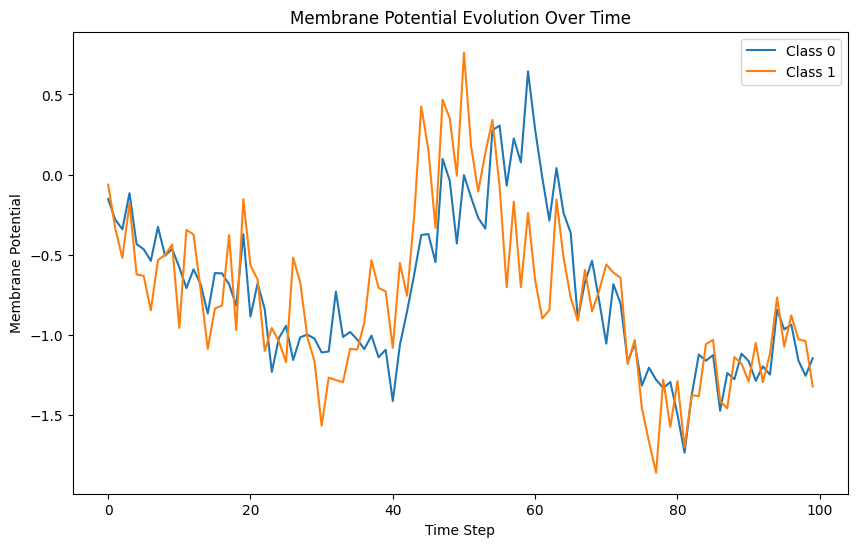

In [30]:
import matplotlib.pyplot as plt

# Select a batch for visualization
inputs, labels = next(iter(test_loader))
# inputs = torch.ones([1,100,100])
mem_out = best_model(inputs)  # (time_steps, batch_size, num_outputs)

# Select first sample in the batch
mem_potentials = mem_out[:, 0, :].cpu().detach().numpy()  # Shape: (time_steps, num_outputs)
time_steps = mem_potentials.shape[0]
num_classes = mem_potentials.shape[1]

# Plot membrane potential over time for each output class
plt.figure(figsize=(10, 6))
for class_idx in range(num_classes):
    plt.plot(range(time_steps), mem_potentials[:, class_idx], label=f"Class {class_idx}")

plt.xlabel("Time Step")
plt.ylabel("Membrane Potential")
plt.title("Membrane Potential Evolution Over Time")
plt.legend()
plt.show()

In [31]:
print(mem_out.shape)
print(labels.shape)
print(inputs.shape)

torch.Size([100, 32, 2])
torch.Size([32])
torch.Size([32, 100, 50])


In [32]:
print(losscustom(mem_out.permute(1,2, 0), labels).item()/inputs.shape[0])

0.003482694970443845


In [ ]:
get_flat_weights(best_model).shape

torch.Size([2652])

In [ ]:
best_model.fc1.weight

Parameter containing:
tensor([[-0.3967, -0.1702, -0.1788,  ...,  0.6425,  0.3367,  0.5097],
        [ 0.1297,  0.5911, -0.4952,  ..., -0.2442, -0.0606,  0.7421],
        [ 0.7845,  0.1208,  0.0635,  ..., -0.3149,  0.2372,  0.2907],
        ...,
        [ 0.2519,  0.0447,  0.4045,  ..., -0.5563,  0.3051,  0.0519],
        [ 0.8454,  0.0061,  0.2771,  ...,  0.7572, -0.3860, -0.1832],
        [ 0.1718, -0.2241, -0.4335,  ..., -0.0078, -0.0687,  0.1098]],
       requires_grad=True)